In [1]:
import os
import pandas as pd
import numpy as np
os.chdir("your/label")

In [2]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [4]:
img_dir = 'Dataset Binary'
label_file = 'Dataset_Labels.xlsx'
df = pd.read_excel(label_file)
df.columns = ['Spine_Name', 'Spine_Label']
print(df.head())

  Spine_Name Spine_Label
0      1.png    Mushroom
1      2.png    Mushroom
2      3.png    Mushroom
3      4.png    Mushroom
4      5.png    Mushroom


In [14]:
import os
import pandas as pd
import numpy as np
from skimage import io
from sklearn.preprocessing import LabelEncoder

# ======================
# Fix the data to divide the file path
# ======================
train_csv = "spine_train_split.csv"
test_csv  = "spine_test_split.csv"
img_dir   = "Dataset Binary"

# ======================
# Load the training/test set
# ======================
train_df = pd.read_csv(train_csv)
test_df  = pd.read_csv(test_csv)

print("Loaded Train/Test split:")
print("Train =", len(train_df), " Test =", len(test_df))
print(train_df['Spine_Label'].value_counts())
print(test_df['Spine_Label'].value_counts())

# ======================
# Convert image → Feature vector
# ======================
X_train, y_train = [], []
for _, row in train_df.iterrows():
    img_path = os.path.join(img_dir, row['Spine_Name'])
    if not os.path.exists(img_path):
        print("Missing:", img_path); continue
    img = io.imread(img_path, as_gray=True)
    X_train.append(img.flatten())
    y_train.append(row['Spine_Label'])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test, y_test = [], []
for _, row in test_df.iterrows():
    img_path = os.path.join(img_dir, row['Spine_Name'])
    if not os.path.exists(img_path):
        print("Missing:", img_path); continue
    img = io.imread(img_path, as_gray=True)
    X_test.append(img.flatten())
    y_test.append(row['Spine_Label'])

X_test = np.array(X_test)
y_test = np.array(y_test)

print("train shape:", X_train.shape)
print("test shape:", X_test.shape)

# ======================
# Tag coding (consistent with RF)
# ======================
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test  = le.transform(y_test)
print("label projection:", dict(zip(le.classes_, le.transform(le.classes_))))


Loaded Train/Test split:
Train = 364  Test = 92
Spine_Label
Mushroom    230
Stubby       90
Thin         44
Name: count, dtype: int64
Spine_Label
Mushroom    58
Stubby      23
Thin        11
Name: count, dtype: int64
训练集图像 shape: (364, 62500)
测试集图像 shape: (92, 62500)
标签映射: {'Mushroom': 0, 'Stubby': 1, 'Thin': 2}


In [5]:
from skimage import transform, util
from skimage.transform import resize
import random
def resize_image(img, target_size=(250, 250)):  
    return resize(img, target_size, mode='edge', anti_aliasing=False)
def augment_image(img):
    augmented_images = []
    
    # 1. rotation
    angle = random.randint(-30, 30)  
    rotated_img = transform.rotate(img, angle, mode='edge')  
    rotated_img = (rotated_img > 0.5).astype(np.uint8) 
    rotated_img = resize_image(rotated_img)
    augmented_images.append(rotated_img)

    # 2. Horizontal flip
    flipped_img = np.fliplr(img)  
    flipped_img = resize_image(flipped_img)
    augmented_images.append(flipped_img)
    
    # 3. Random scaling
    scale_factor = random.uniform(0.8, 1.2)  
    scaled_img = transform.rescale(img, scale_factor, mode='edge')  
    scaled_img = (scaled_img > 0.5).astype(np.uint8)  
    scaled_img = resize_image(scaled_img)
    augmented_images.append(scaled_img)

    # 4. Translation
    tx = random.randint(-5, 5)  
    ty = random.randint(-5, 5)  
    translated_img = transform.warp(img, transform.AffineTransform(translation=(tx, ty)), mode='edge')
    translated_img = (translated_img > 0.5).astype(np.uint8)  
    translated_img = resize_image(translated_img)
    augmented_images.append(translated_img)

    
    return augmented_images

In [15]:
from skimage import io
data = []
labels = []
shape = []
for index, row in df.iterrows():
    file_name = row['Spine_Name']
    label = row['Spine_Label']
    img_path = os.path.join(img_dir, file_name)
    if not os.path.exists(img_path):
        print(f"Can't find {file_name}")
        continue
    img = io.imread(img_path,as_gray=True)
    if img_path is None:
        print(f"The image is damaged")
        continue
    flat_data = img.flatten()
    data.append(flat_data)
    labels.append(label) 
X = np.array(data)
y_text = np.array(labels)
if len(set(len(x) for x in X)) > 1:
    print("Please resize the image to the same size")
print(f"data loading finished")
print(f"Feature matrix shape: {X.shape}")

数据加载完毕。
特征矩阵形状: (456, 62500)


In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y_text)
print("Category correspondence:", dict(zip(le.classes_, le.transform(le.classes_))))

类别对应: {'Mushroom': 0, 'Stubby': 1, 'Thin': 2}


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
augmented_data = []
augmented_labels = []
for i in range(len(X_train)):
    img = X_train[i].reshape((250,250)) #（250，250）--> image size
    label = y_train[i]
    augmented_data.append(X_train[i])  # add primary data
    augmented_labels.append(label)
    
    # Perform data augmentation for the Stubby or Thin category
    if label == 1 or label == 2:
        augmented_images = augment_image(img)
        for aug_img in augmented_images:
            augmented_data.append(aug_img.flatten()) 
            augmented_labels.append(label)
X_train_augmented = np.array(augmented_data)
print(f"Feature matrix: {X_train_augmented.shape}")
y_train_augmented = np.array(augmented_labels)
clf = svm.SVC(kernel='linear', degree=2, C=0.5)
clf.fit(X_train_augmented, y_train_augmented)



特征矩阵形状: (900, 62500)


SVC(C=0.5, degree=2, kernel='linear')

0.7934782608695652


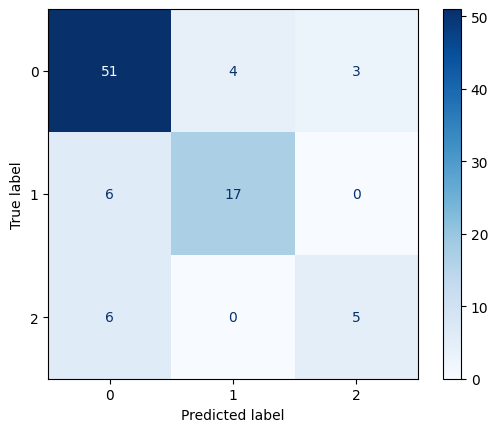

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(accuracy)

In [19]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10], 
    'kernel': ['linear'],         
    'degree': [2, 3, 4]

}

svm_model = svm.SVC()
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)


print("Best cross-validation score: ", grid_search.best_score_)


results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Score: {mean_score:.4f}, Parameters: {params}")

# Select the best model
best_model = grid_search.best_estimator_

# ===== save the optimal SVM model =====
import joblib
joblib.dump(best_model, "spine_svm_model.joblib")
print("SVM best model saved to spine_svm_model.joblib")


Fitting 5 folds for each of 9 candidates, totalling 45 fits


Error processing line 1 of /opt/miniconda3/envs/wd/lib/python3.8/site-packages/distutils-precedence.pth:

Error processing line 1 of /opt/miniconda3/envs/wd/lib/python3.8/site-packages/distutils-precedence.pth:

Error processing line 1 of /opt/miniconda3/envs/wd/lib/python3.8/site-packages/distutils-precedence.pth:

Error processing line 1 of /opt/miniconda3/envs/wd/lib/python3.8/site-packages/distutils-precedence.pth:

  Traceback (most recent call last):
    File "/opt/miniconda3/envs/wd/lib/python3.8/site.py", line 177, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored
  Traceback (most recent call last):
    File "/opt/miniconda3/envs/wd/lib/python3.8/site.py", line 177, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored
  Traceback (most recent call last):
    File "/opt/mi

[CV] END .....................C=0.1, degree=2, kernel=linear; total time=   2.8s
[CV] END .....................C=0.1, degree=3, kernel=linear; total time=   2.8s
[CV] END .....................C=0.1, degree=3, kernel=linear; total time=   2.9s
[CV] END .....................C=0.1, degree=2, kernel=linear; total time=   3.0s
[CV] END .....................C=0.1, degree=2, kernel=linear; total time=   3.1s
[CV] END .....................C=0.1, degree=2, kernel=linear; total time=   3.3s
[CV] END .....................C=0.1, degree=3, kernel=linear; total time=   3.3s
[CV] END .....................C=0.1, degree=3, kernel=linear; total time=   3.4s
[CV] END .....................C=0.1, degree=2, kernel=linear; total time=   3.6s
[CV] END .....................C=0.1, degree=4, kernel=linear; total time=   2.4s
[CV] END .....................C=0.1, degree=3, kernel=linear; total time=   2.6s
[CV] END .....................C=0.1, degree=4, kernel=linear; total time=   2.6s
[CV] END ...................

0.8260869565217391


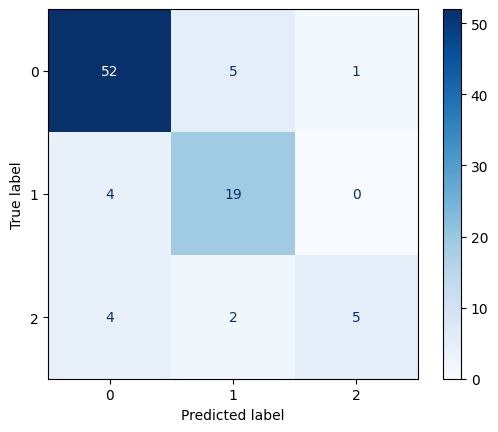

In [20]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(accuracy)